In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import daolib.dao as dao
import daolib.dso as dso
import util.sectool as sectool
import matplotlib.pyplot as plt
%matplotlib inline

## 特征值

In [15]:
risk_beta = dao.get_style_risk_factor('risk_beta','zz')
risk_bp = dao.get_style_risk_factor('risk_bp','zz')
risk_ey = dao.get_style_risk_factor('risk_ey','zz')
risk_gro = dao.get_style_risk_factor('risk_gro','zz')
risk_lev = dao.get_style_risk_factor('risk_lev','zz')
risk_liq = dao.get_style_risk_factor('risk_liq','zz')
risk_mom = dao.get_style_risk_factor('risk_mom','zz')
risk_mv = dao.get_style_risk_factor('risk_mv','zz')
risk_nlmv = dao.get_style_risk_factor('risk_nlmv','zz')
risk_vol = dao.get_style_risk_factor('risk_vol','zz')

#股票上市状态(只选择为0的值，不为0的值为异常值)
price_df=dao.get_security_info('stock_price_info')
trade_status_df=price_df.xs('trade_status',level=1)

In [16]:
#时间间隔（月/天）
trade_date_m_list = dso.get_trade_date(start_date=dt.datetime(2009,4,4), end_date=dt.datetime(2018,10,31), period='m')
trade_date_d_list = dso.get_trade_date(start_date=dt.datetime(2007,1,4), end_date=dt.datetime(2018,10,31), period='d')

In [17]:
#读取月度数据
risk_beta_df=risk_beta.loc[:,trade_date_m_list]
risk_bp_df=risk_bp.loc[:,trade_date_m_list]
risk_ey_df=risk_ey.loc[:,trade_date_m_list]
risk_gro_df=risk_gro.loc[:,trade_date_m_list]   #2009年4月份后才有完整数据
risk_lev_df=risk_lev.loc[:,trade_date_m_list]
risk_liq_df=risk_liq.loc[:,trade_date_m_list]
risk_mom_df=risk_mom.loc[:,trade_date_m_list]
risk_mv_df=risk_mv.loc[:,trade_date_m_list]
risk_nlmv_df=risk_nlmv.loc[:,trade_date_m_list]
risk_vol_df=risk_vol.loc[:,trade_date_m_list]

#### 分类标签

In [18]:
# 分类标准（以涨跌幅划分，前t%标记为1，后t%标记位-1，中间标记为0），作为预测分类标签
stock_price_df = dao.get_security_info('stock_price_info')  #股票涨跌幅（月频数据）
pct_chg=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
def fun(x,i,t):
    u=pct_chg[i].sort_values(ascending=False)
    u.dropna(inplace=True)
    n=int(len(u)*t)
    #按照涨跌幅前t%，后t%分类
    s1=u[0:n].values
    s2=u[-n:].values
    if  x in s1:
        return 1
    elif x in s2:
        return -1
    else:
        return 0
def pct_class_creat(t):
    pct_chg_class=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)  
    for i in pct_chg.columns:
        pct_chg_class[i]=pct_chg[i].apply(lambda x: fun(x,i,t))     #以t%为阈值
    return pct_chg_class

In [21]:
def pct_class_creat2(t):
    stock_price_df = dao.get_security_info('stock_price_info')  #股票涨跌幅（月频数据）
    pct_chg=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)  
    rise_quatile_percent = t
    rise_quan30_series = pct_chg.quantile(rise_quatile_percent)
    rise_quan70_series = pct_chg.quantile(1.0 - rise_quatile_percent)

    pct_chg[pct_chg>rise_quan70_series] = 999
    pct_chg[pct_chg<rise_quan30_series] = -999
    pct_chg[pct_chg.abs() != 999] = np.nan

    pct_chg.replace(to_replace=[-999, 999], value=[-1, 1], inplace=True)
    pct_chg.fillna(0,inplace=True)
    return pct_chg    

In [24]:
# pct_chg_class1

In [22]:
pct_chg_class1=pct_class_creat2(0.1)
pct_chg_class2=pct_class_creat2(0.2)
pct_chg_class3=pct_class_creat2(0.3)

#### 空值填充

In [26]:
#按照行业均值进行填充
industry_class_df=dao.get_stock_industry_data('CS')               #股票行业信息----周频信息
industry_class_m_df=industry_class_df.loc[:,trade_date_m_list]    #股票行业信息----月频信息
#按照行进行填充，下一个值
industry_class_m_df=industry_class_m_df.fillna(method='bfill',axis=1)
industry_class_m_df=industry_class_m_df.fillna('未知')  
#按照行业均值进行填充
def fillna_ind_mean(data):
    for i in range(1,len(trade_date_m_list)):
        resl_series = pd.Series() 
        industry_series=industry_class_m_df.iloc[:,i]
        group_data = industry_series.index.groupby(industry_series.values) 
        industry_list = list(group_data.keys())   
        data_series=data.iloc[:,i]
        for industry_name in industry_list:      
            industry_temp = data_series.loc[group_data[industry_name]]
            industry_temp = industry_temp.fillna(industry_temp.mean())         
            resl_series = resl_series.append(industry_temp)
        stock_list = list(set(data_series.index) - set(industry_series.dropna().index))
        resl_series = resl_series.append(data_series.loc[stock_list])
        data.iloc[:,i]=resl_series
    return data

#只做均值填充
def data_fillna_mean(df):
    df=fillna_ind_mean(df)
    return df
#先均值填充，再前后填充
def data_fillna_mean_bf(df):
    df=fillna_ind_mean(df)
    df=df.fillna(method='bfill',axis=1)
    df=df.fillna(method='ffill',axis=1)
    return df

In [27]:
risk_beta_mean_bf_df=data_fillna_mean_bf(risk_beta_df)
risk_bp_mean_bf_df=data_fillna_mean_bf(risk_bp_df)
risk_ey_mean_bf_df=data_fillna_mean_bf(risk_ey_df)
risk_gro_mean_bf_df=data_fillna_mean_bf(risk_gro_df)  
risk_lev_mean_bf_df=data_fillna_mean_bf(risk_lev_df)
risk_liq_mean_bf_df=data_fillna_mean_bf(risk_liq_df)
risk_mom_mean_bf_df=data_fillna_mean_bf(risk_mom_df)
risk_mv_mean_bf_df=data_fillna_mean_bf(risk_mv_df)
risk_nlmv_mean_bf_df=data_fillna_mean_bf(risk_nlmv_df)
risk_vol_mean_bf_df=data_fillna_mean_bf(risk_vol_df)

## 只选4个显著特征值

In [28]:
def pctdata_join(pct_chg_class):
    data_pct=pd.DataFrame()
    for i in risk_beta_df.columns:
        stock_pct_factor=(pd.concat([risk_beta_mean_bf_df[i],risk_ey_mean_bf_df[i],risk_liq_mean_bf_df[i],risk_vol_mean_bf_df[i],pct_chg_class[i],trade_status_df[i]],axis=1)).reset_index()
        stock_pct_factor.columns=['stock','risk_beta','risk_ey','risk_liq','risk_vol','pct_chg_class','trade_status']
        stock_pct_factor['date']=i
        data_pct=data_pct.append(stock_pct_factor)
    return data_pct

In [29]:
#统计股票在115个月出现的次数
def Stock_count(data):
    stock_list=(data['stock'].value_counts()).sort_values()      #统计股票出现次数，并升序排序
    print("有数据的股票支数:",len( stock_list))
    # print("115个月内都有数据的股票支数:",len(lis[lis==115]))   #统计115个月内都有数据的股票
    x=[]
    y=[]
    stock_select=[]
    for i in range(1,116):
        x.append(i)
        y.append(len(stock_list[stock_list==i]))
        stock_select.append([i,stock_list[stock_list==i].index])
#         print(i,"个月内都有数据的股票支数:",len(lis[lis==i]))   
    #     print(i,len(lis[lis==i]))
    plt.plot(x,y)     
    plt.title('stock number in x-months ')
    plt.axhline(115/2,color='red')
#     plt.show()
    return stock_select

In [30]:
#划分测试集合/训练集合
def data_train_test(data_pct):
#     data_pct_test=data_pct.fillna(0)       #包含0，-1,1的三种分类的全部数据预测集
#     data_pct_test=data_pct      #包含0，-1,1的三种分类的全部数据预测集
    data_pct_test=data_pct[data_pct['trade_status']==0]       #选择正常股票状态的数据
    data_pct_test=data_pct_test.dropna()    #删除空值
    data_pct_train=data_pct[~data_pct['pct_chg_class'].isin([0])]        #不包含0的训练集
    data_pct_train=data_pct_train[data_pct_train['trade_status']==0]       #选择正常股票状态的数据
    #直接删除空值？？？其余处理方式？？
    data_pct_dropna_train=data_pct_train.dropna()
    #筛选出只出现一次的股票（以月为单位）,删除只有一行数据的股票，后面会报错numpy
    data_pct_drop_train_select=Stock_count(data_pct_dropna_train)
    temp=[]
    for i in data_pct_drop_train_select[0][1]:
        temp.append(i)
    data_pct_drop_train=data_pct_dropna_train[~(data_pct_dropna_train['stock'].isin(temp))]
    return data_pct_drop_train,data_pct_test

有数据的股票支数: 3546
有数据的股票支数: 3573
有数据的股票支数: 3575


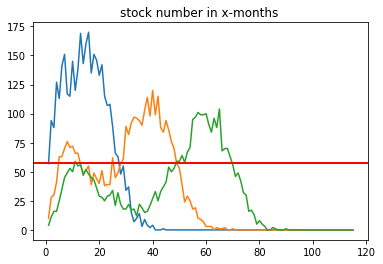

In [73]:
pct_chg_class1_data=pctdata_join(pct_chg_class1)
pct_chg_class2_data=pctdata_join(pct_chg_class2)
pct_chg_class3_data=pctdata_join(pct_chg_class3)

Class10_train,Class10_test=data_train_test(pct_chg_class1_data)
Class20_train,Class20_test=data_train_test(pct_chg_class2_data)
Class30_train,Class30_test=data_train_test(pct_chg_class3_data)

In [ ]:
import numpy as np
from sklearn.decomposition import pca
from pyhht.emd import EMD
from pyhht.visualization import plot_imfs


# data=Class10_train['risk_beta'].reset_index()
# data['risk_beta']
# decomposer=EMD()              
# imfs = decomposer.decompose()
# plot_imfs(data['risk_beta'],imfs,data.index)

In [103]:
len(IMFs) 
# print(s)
for i in IMFs:
    print(len(i))

100
100
100
100
100
100
100


#### 标准化

In [34]:
# 可以处理空值
def Standard(X_train,X_test):
    X_train_scaled =1.0 * (X_train - X_train.mean()) / X_train.std()  # 数据标准化
    X_test_scaled =1.0 * (X_test - X_test.mean()) / X_test.std()  # 数据标准化
    return  X_train_scaled,X_test_scaled 

#### 划分测试集、训练集

In [35]:
#两分类划分，划分训练集data，测试集alldata（训练集的类别只有（0,1），测试集包含所有类别（0,1，-1））
def Splitdata2(data,alldata,i,j,x,y):
    #按月份计数
    resultdata=(data['stock'].groupby(data['date'])).describe()
    resultalldata=(alldata['stock'].groupby(alldata['date'])).describe()
    resultdata['sum']=resultdata['count'].cumsum()
    resultalldata['sum']=resultalldata['count'].cumsum()
    i=resultdata['sum'][i]
    j=resultdata['sum'][j]
    x=resultalldata['sum'][x]
    y=resultalldata['sum'][y]
    
    X_train=np.array(data[['risk_beta','risk_ey','risk_liq','risk_vol','stock','date']][j:i])
    Y_train=np.array(data['pct_chg_class'][j:i])
    #第x个月，测试集
    X_test=np.array(alldata[['risk_beta','risk_ey','risk_liq','risk_vol','stock','date']][x:y])
    Y_test=np.array(alldata['pct_chg_class'][x:y])
    X_train_scaled,X_test_scaled=Standard(X_train[:,:-2],X_test[:,:-2])
    return X_train_scaled,X_test_scaled,Y_train,Y_test,X_test

In [36]:
#三类划分
def Splitdata3(data,i,j,x,y):
    #按月份计数
    resultdata=(data['stock'].groupby(data['date'])).describe()
    resultdata['sum']=resultdata['count'].cumsum()
    i=resultdata['sum'][i]
    j=resultdata['sum'][j]
    x=resultdata['sum'][x]
    y=resultdata['sum'][y]
    #j月-i月
    X_train=np.array(data[['risk_beta','risk_ey','risk_liq','risk_vol','stock','date']][j:i])
    Y_train=np.array(data['pct_chg_class'][j:i])
    #第x个月，测试集
    X_test=np.array(data[['risk_beta','risk_ey','risk_liq','risk_vol','stock','date']][x:y])
    Y_test=np.array(data['pct_chg_class'][x:y])
    X_train_scaled,X_test_scaled=Standard(X_train[:,:-2],X_test[:,:-2])
    return X_train_scaled,X_test_scaled,Y_train,Y_test,X_test

#### 概率预测

In [37]:
from sklearn.linear_model import LogisticRegression
# 预测概率值（没有Y_test来检验）
def LR_probo(X_train,Y_train,X_test,Y_test,columns1,columns2,Xx_test):
    clf = LogisticRegression()  
    clf.fit(X_train, Y_train)  
#     print(clf.predict(X_test))            #   返回预测标签  
    probo=clf.predict_proba(X_test)    # 返回预测属于某标签的概率   
    probo=pd.DataFrame(probo,columns=[columns1,columns2])    
    probo['STOCK']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
#     probo['PCT_CHG']=Y_test
    return probo

from sklearn import svm
# 预测概率值（没有Y_test来检验）
def SVM_probo(X_train,Y_train,X_test,Y_test,columns1,columns2,Xx_test):
    clf = svm.SVC(probability=True)  
    clf.fit(X_train, Y_train)  
#     print(clf.predict(X_test))       #   返回预测标签  
    probo=clf.predict_proba(X_test)      # 返回预测属于某标签的概率  
    probo=pd.DataFrame(probo,columns=[columns1,columns2])
    probo['STOCK']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
    return probo

#SVM多分类(很慢)
def NSVM_probo(X_train,Y_train,X_test,Y_test,columns1,columns2,columns3,Xx_test):
    from sklearn.multiclass import OneVsRestClassifier
    clf = OneVsRestClassifier(svm.SVC(probability=True))
#     clf = svm.SVC(probability=True)  
    clf.fit(X_train, Y_train)   
#     print(clf.predict(X_test))        #   返回预测标签  
    probo=clf.predict_proba(X_test)   
    probo=pd.DataFrame(probo,columns=[columns1,columns2,columns3])
    probo['STOCK']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
#     probo['PCT_CHG']=Y_test
    return probo

In [38]:
#从2009年4月来计算因子值，逐月扩展（以24个月为间隔滚动）,model：为预测模型：LR,SVM,RFC.....
def pct_probo(data_pct_drop_train,data_pct_test,model):
    allprobo_pct_df=[]
    for m in range(len(trade_date_m_list)-24):
        X_train, X_test, Y_train, Y_test,Xx_test= Splitdata2(data_pct_drop_train,data_pct_test,m+23,m,m+23,m+24)
        probo_pct=model(X_train,Y_train,X_test,Y_test,'1','-1',Xx_test)
        allprobo_pct_df.append(probo_pct)
    return allprobo_pct_df

In [40]:

# SVM_probo10_df=pct_probo(Class10_train,Class10_test,SVM_probo)
# NSVM_probo10_df=pct_probo(Class10_train,Class10_test,NSVM_probo)

In [41]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def LightGBM(data,X_train,y_train,X_test,y_test,Xx_test):
    lgb_train = lgb.Dataset(X_train, y_train)   # 创建成lgb特征的数据集格式
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    gbm = lgb.LGBMClassifier(boosting_type='gbdt',learning_rate = 0.01,num_leaves = 35,)
    gbm.fit(X_train,y_train)
    y_pred=gbm.predict(X_test,num_iteration=gbm.best_iteration_)
    probo=gbm.predict_proba(X_test)
    probo=pd.DataFrame(probo)
    probo['stock']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
    return probo


def pct_LightGBM_probo(data):
    allprobo_pct_df=[]
    for m in range(len(trade_date_m_list)-24):
        X_train, X_test, Y_train, Y_test,Xx_test= Splitdata3(data,m+23,m,m+23,m+24)
        probo_pct=LightGBM(data,X_train,Y_train,X_test,Y_test,Xx_test)
        allprobo_pct_df.append(probo_pct)
    return allprobo_pct_df

lightgbm_probo_df=pct_LightGBM_probo(Class10_test)

In [74]:
LR_probo10_df=pct_probo(Class10_train,Class10_test,LR_probo)
LR_probo20_df=pct_probo(Class20_train,Class20_test,LR_probo)
LR_probo30_df=pct_probo(Class30_train,Class30_test,LR_probo)

In [68]:
import itertools
date=trade_date_m_list[24:]

def change(data,n,m):
    factor_df=pd.DataFrame(columns=date)
    factor_df['stock']=list(risk_beta_df.index)
    for i,t in itertools.zip_longest(data,date):
        temp=factor_df[['stock']]
        temp[t]=np.nan
        u=i.iloc[:,[n,m]]
        u.columns=[t,'stock']
        factor_Crash=pd.concat([u,temp],join='inner',ignore_index=True)
        factor_Crash.sort_values(t,inplace=True)
        factor_Crash.drop_duplicates(['stock'],inplace=True)
        factor_Crash.sort_values('stock',inplace=True)
        factor_Crash.reset_index(inplace=True)
        factor_df[t]= factor_Crash[t]
    factorF_df=factor_df.set_index(['stock'])
    return factorF_df

def changeindex(data):
    factor0_df=change(data,0,2)
    factor1_df=change(data,1,2)
    return  factor0_df,factor1_df

def changeindex3(data):
    factor0_df=change(data,0,3)
    factor1_df=change(data,1,3)
    factor2_df=change(data,2,3)
    return  factor0_df,factor1_df,factor2_df

In [75]:
LR_tail10_df,LR_top10_df=changeindex(LR_probo10_df)
LR_tail20_df,LR_top20_df=changeindex(LR_probo20_df)
LR_tail30_df,LR_top30_df=changeindex(LR_probo30_df)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
lightgbm_pct10_0,lightgbm_pct10_1,lightgbm_pct10_2=changeindex3(lightgbm_probo_df)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [45]:
import util.factortool as ftool

def factor_test_T(factor_list,factor_name): 
    risk_test=pd.DataFrame()
    for i ,n in itertools.zip_longest(factor_list,factor_name):
        risk_test[n]=ftool.factor_risk_test_tvalue(i)
    return  risk_test

factor_list=[lightgbm_pct10_0,lightgbm_pct10_1,lightgbm_pct10_2]
factor_name=['lightgbm_pct10_0','lightgbm_pct10_1','lightgbm_pct10_2']
    
risk_test=factor_test_T(factor_list,factor_name)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [46]:
risk_test

,lightgbm_pct10_0,lightgbm_pct10_1,lightgbm_pct10_2
risk_beta,5.031144,-7.677591,7.639960
risk_mv,1.868064,-1.202765,-0.154780
risk_bp,-2.385089,3.658102,-3.867026
risk_mom,1.776930,-1.638721,0.734998
risk_ey,-1.399680,1.459193,-0.719024
risk_lev,-0.733511,0.878740,-0.667198
risk_liq,11.587880,-9.175886,2.420956
risk_gro,-0.062212,-0.399207,0.810857
risk_vol,41.305950,-44.737916,31.889115
risk_nlmv,2.322399,-2.099886,0.923841


In [76]:
LR_tail10_obj=factor_analyse1('LR-1',LR_tail10_df)
LR_top10_obj=factor_analyse0('LR+1',LR_top10_df)

LR_tail20_obj=factor_analyse1('LR-1',LR_tail20_df)
LR_top20_obj=factor_analyse0('LR+1',LR_top20_df)

LR_tail30_obj=factor_analyse1('LR-1',LR_tail30_df)
LR_top30_obj=factor_analyse0('LR+1',LR_top30_df)

因子 LR-1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:32 Time:  0:01:32

| |     #                                            | 89 Elapsed Time: 0:00:19
因子 LR+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:38 Time:  0:01:38

| |#                                                 | 89 Elapsed Time: 0:00:19
因子 LR-1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:30 Time:  0:01:30

| |           #                                      | 89 Elapsed Time: 0:00:18
因子 LR+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:38 Time:  0:01:38

| |       #                                          | 89 Elapsed Time: 0:00:19


In [51]:
lightgbm_pct10_0=factor_analyse('lightgbm+1',lightgbm_pct10_0,1)
lightgbm_pct10_1=factor_analyse('lightgbm+1',lightgbm_pct10_1,0)
lightgbm_pct10_2=factor_analyse('lightgbm+1',lightgbm_pct10_2,0)

因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:41 Time:  0:01:41

| |                    #                             | 89 Elapsed Time: 0:00:22
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:40 Time:  0:01:40

| |                           #                      | 89 Elapsed Time: 0:00:22
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:44 Time:  0:01:44

| |                             #                    | 89 Elapsed Time: 0:00:22


In [ ]:
show2(lightgbm_pct10_1)

In [66]:
show2(lightgbm_pct10_2)

,年化收益率,最大回撤,月胜率
long_short,-0.000562,0.164557,0.455556
300_hedge,0.012818,0.402597,0.522222
500_hedge,0.040336,0.193821,0.555556


In [ ]:
LR_tail10_obj=factor_analyse1('LR-1',LR_tail10_df)
LR_top10_obj=factor_analyse0('LR+1',LR_top10_df)

In [77]:
show2(LR_tail20_obj)

,年化收益率,最大回撤,月胜率
long_short,0.032932,0.119727,0.600000
300_hedge,0.044345,0.391709,0.588889
500_hedge,0.059488,0.192934,0.555556


In [78]:
show2(LR_top20_obj)

,年化收益率,最大回撤,月胜率
long_short,0.037306,0.120424,0.600000
300_hedge,0.048123,0.362525,0.588889
500_hedge,0.063070,0.155451,0.555556


In [48]:
import alphafactors.factorprepro_class as fp
import alphafactors.factoranalyse as fa

#因子处理(分成两种方向)
def factor_analyse(name,factor,n):  # n=0-positive , n=1-negetive
    factor_prepro_obj = fp.FactorPrePro(factor_name=name, factor_data_df=factor, universe='ZZ', neutral_list=None)
    factor_prepro_obj.run_process(start_date=max(factor.columns[0], dt.datetime(2007,1,5)), end_date=factor.columns[-1])
    df = factor_prepro_obj.factor_pro_df
    factor_test_obj = fa.FactorAnalyse(factor_name=name, factor_data_df=df, factor_dr=n)   # 0-positive , 1-negetive
    factor_test_obj.run_analyse_new(start_date=dt.datetime(2009,1,23), universe='ZZ')
    return factor_test_obj

#因子测试画图显示
def show1(factor_test_obj):
    factor_test_obj.net_value_df.iloc[:,-3:].plot(figsize=(20,10))
def show2(factor_test_obj):
    factor_test_obj.factor_perform_df
    return  factor_test_obj.factor_perform_df
def show3(factor_test_obj):
    factor_test_obj.factor_para_df
    return  factor_test_obj.factor_para_df
def show4(factor_test_obj):
    factor_test_obj.port_perform_df
    return     factor_test_obj.port_perform_df
def show5(factor_test_obj):
    factor_test_obj.port_perform_df['annual_return'].plot(kind='bar')
    return factor_test_obj.port_perform_df['annual_return'].plot(kind='bar')   
def show6(factor_test_obj):
    factor_test_obj.factor_index_df['IC值'].plot(kind='bar', figsize=(20,10), color='blue')
    return  factor_test_obj.factor_index_df['IC值'].plot(kind='bar', figsize=(20,10), color='blue')

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def lightgbm(X_train, y_train,X_test, y_test):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    # specify your configurations as a dict
    params = {'task': 'train','boosting_type': 'gbdt','metric': {'l2', 'auc'},'num_leaves': 31,'learning_rate': 0.05,'feature_fraction': 0.9,'verbose': 1}
    print('Start training...')
    # train
    gbm = lgb.train(params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=50)
    print('Start predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # eval
    print(y_pred)
    print('The roc of prediction is:', roc_auc_score(y_test, y_pred) )
    print('Feature names:', gbm.feature_name())
    print('Calculate feature importances...')
    # feature importances
    print('Feature importances:', list(gbm.feature_importance()))